# **Reporte Hito 3**

**Fecha:** Noviembre 2022

**Autores:** Armin Rodríguez, Rodrigo Valenzuela, Nicolás Hidalgo, Pablo Nahuelpán

## **Índice de contenidos**
* [Introducción](#item1)
* [Cargando conjunto de datos y librerías](#item2)
* [Limpieza de dataset](#item3)
* [Exploración de Datos](#item4)
* [Preguntas y Problemas](#item5)
* [Propuesta Experimental](#item6)
* [Experimento preliminar](#item7)
* [Trabajo realizado](#item8)
* [Referencias](#item9)
* [Anexo](#item10)

<a name="item1"></a>
## **Introducción**

Hearthstone es un juego de cartas coleccionables creado por la empresa Blizzard [1]. Este juego ha visto hasta 6.5 millones de jugadores concurrentes y debido a su popularidad sitios como Hearthpwn.com [2] fueron desarrollados para permitirle a los jugadores una herramienta para crear y compartir mazos de prueba.

Heartpwn nos ha encargado con la búsqueda de factores que permitan clasificar mazos de cartas en categorías que no estaban definidas dentro de las diferentes plataformas que serán futuramente absorbidas por el sitio. Esto con el objetivo de clasificar los datos no cubiertos por ellas como los nuevos formatos de juegos implementados que son estándar y salvaje.

En este reporte se analizarán resultados relacionados a la clasificación de mazos a través de las categorías provistas por parte de Heartpwn para asistir en la introducción de datos de mazos externos a su plataforma además de incorporar la tarea de análisis de asociaciones de los atributos de mazos para implementar una sección de recomendaciones de mazos en la plataforma. El objetivo final siendo el desarrollo de uno o más modelos experimentales que puedan asistir a la tarea de clasificación y el desarrollo del uso de un modelo de asociación de atributos.

En el conjunto de datos se encuentran registrados distintos mazos subidos a la plataforma de Heartpwn desde el año 2013 hasta 2017 y fueron proporcionados por el sitio Kaggle [5].

<a name="item2"></a>
## **Cargando conjunto de datos y librerias**
Se realiza la carga del conjunto de datos [5] para trabajar.

In [ ]:
# Se ejecuta para poder cargar código de R que teníamos anteriormente.
!pip install kmodes
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import collections
import statsmodels.api as sm
import numpy as np

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
decks <- read.csv2("https://raw.githubusercontent.com/ArminRodriguez1/ig_Datos/main/data.csv")
head(decks)

  craft_cost       date deck_archetype deck_class deck_format deck_id  deck_set
1       9740 19/02/2016        Unknown     Priest           W  433004 Explorers
2       9840 19/02/2016        Unknown    Warrior           W  433003 Explorers
3       2600 19/02/2016        Unknown       Mage           W  433002 Explorers
4      15600 19/02/2016        Unknown    Warrior           W  433001 Explorers
5       7700 19/02/2016        Unknown    Paladin           W  432997 Explorers
6       5740 19/02/2016        Unknown    Warrior           W  432995 Explorers
     deck_type rating                           title         user card_0
1 Tavern Brawl      1                     Reno Priest    FunKaliTy      9
2  Ranked Deck      1                  RoosterWarrior RooosterRooo     75
3  Theorycraft      1                        Annoying      Messalm    195
4         None      0     Standart pay to win warrior    KingSneak     75
5  Ranked Deck      1                         Palamix  kowdog_1507    

In [ ]:
decks = %R decks

Como podemos ver el dataset se compone de clases que hacen referencia a un mazo de cartas y las columnas donde sus atributos entregan datos como la fecha en que se creó el mazo, también a qué formato de juego pertenece o a qué arquetipo pertenece el mazo donde el arquetipo del mazo se refiere al estilo de juego que tiene el mazo de cartas y también esta el atributo "deck_class" que hace referencia a la clase del mazo ya que en este juego se pueden jugar con distintas clases que tienen cartas únicas.

<a name="item3"></a>
##**Limpieza de dataset**

Se realiza una limpieza de las variables no relevantes, con grandes cantidades de variables vacías, incorrectas o faltantes. Lo primero que se realizó fue evaluar las variables que no tenían relevancia en el contexto planteado, dejando solo las variables deseadas, posteriormente se limpiaron dichas variables dejando únicamente las que ofrecían información relevante para el contexto.

Varaibles no relevantes : 
* craft_cost
* title
* user
* rating
* deck_id

Se tiene en la mira la variable con datos faltantes, erróneos o nulos

* deck_archetype

Tenemos que verificar si esta variable puede ser relevante para la propuesta experimental, en caso de ser afirmativo, entonces se tiene pensado limpiar los datos dejando solo los valores que son conocidos y eliminar los datos desconocidos de dicha variable.

El dataset actualmente contiene datos desde el año 2013, esto no es algo favorable para lo que necesitamos, ya que en ese momento el juego estaba en fase "beta", por lo tanto las cartas y decks no son relevantes para el análisis final. Por lo que se eliminara los datos que sean anterior al 11 de marzo del 2014. Siendo esta la fecha de salida del juego para todo público. 

In [ ]:
filter_deck = decks.copy()
filter_deck.drop(['craft_cost', 'title', 'user', 'rating', 'deck_id'], axis = 'columns', inplace=True)
filter_deck.head()
column_list = filter_deck.columns
total_rows=len(filter_deck.axes[0])
print("Cantidad de filas presentes luego del filtrado: "+str(total_rows))
print('Cantidad de columnas presentes luego del filtrado:', len(column_list))

Cantidad de filas presentes luego del filtrado: 346232
Cantidad de columnas presentes luego del filtrado: 36


In [ ]:
filter_deck['date'] = pd.to_datetime(decks['date'])
print ('Primero Mazo :', min(filter_deck['date']))
print ('Ultimo Mazo :', max(filter_deck['date']))

Primero Mazo : 2013-01-06 00:00:00
Ultimo Mazo : 2017-12-03 00:00:00


Comprobamos que el primer mazos del dataset es del 23-05-2013, un año antes del lanzamiento oficial, por lo tanto, los mazos inferiores al año 2014 son mazos irrelevantes para nuestro análisis por lo que como se mencionó se eliminaran desde la fecha definida.

In [ ]:
filter_deck = filter_deck[filter_deck['date'] > '2014-03-11']
print ('Primero Mazo :', min(filter_deck['date']))
print ('Ultimo Mazo :', max(filter_deck['date']))

Primero Mazo : 2014-03-12 00:00:00
Ultimo Mazo : 2017-12-03 00:00:00


También hay que destacar que el modo de juego con los dos formatos es anunciado el 02 de febrero del 2016 confirmado por la página oficial de hearthstone por lo que empezaría por el lanzamiento de la expansión de "Old Gods" [6], y principalmente en este periodo existen probabilidades de que las predicciones o clasificaciones que realizaban otros sitios no tengan un buen respaldo y no sean del todo correctas, por lo tanto nosotros vamos a trabajar con este periodo en particular para tener un buen análisis y clasificación de datos para este periodo dentro del sitio de hearthpwn.

Primero identificamos si en el dataset existe esta expansión dentro de la variable "deck_set" que hace referencia a una expansión de cuando se registró un mazo.

In [ ]:
filter_deck["deck_set"].unique()

array(['Explorers', 'Old Gods', 'Classic Nerfs', 'Karazhan', 'Yogg Nerf',
       'Gadgetzan', 'Aggro Downfall', 'Live Patch 5314', 'Naxx Launch',
       'Live Patch 5170', 'Beta Patch 4243', 'GvG Launch',
       'Live Patch 5506', 'Undertaker Nerf', 'Blackrock Launch',
       'TGT Launch', 'Live Patch 4973', 'Beta Patch 4944',
       'Beta Patch 4482', 'Warsong Nerf', 'GvG Prelaunch',
       'Live Patch 5435'], dtype=object)

Comprobamos que sí existen mazos que fueron registrados en la expansión "Old Gods" y ahora filtramos para utilizar todos los mazos de este periodo.

In [ ]:
filter_deck = filter_deck[filter_deck['deck_set'] == 'Old Gods']
filter_deck.head()

,date,deck_archetype,deck_class,deck_format,deck_set,deck_type,card_0,card_1,card_2,card_3,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
1407,2016-04-26,Mill Rogue,Rogue,S,Old Gods,Ranked Deck,180,180,196,196,...,1158,2291,2291,2304,2304,2949,38888,38888,39041,39041
1497,2016-04-26,N'Zoth Hunter,Hunter,W,Old Gods,Ranked Deck,296,296,437,437,...,38496,38584,38584,38727,38727,38734,38734,38875,38875,38910
1498,2016-04-26,Unknown,Druid,S,Old Gods,None,64,64,95,137,...,38718,38857,38859,38859,38863,38863,38868,38868,38882,38882
1499,2016-04-26,C'Thun Priest,Priest,S,Old Gods,Ranked Deck,272,272,613,613,...,38863,38863,38868,38868,38958,38958,39033,39033,39041,39041
1622,2016-04-26,Unknown,Mage,S,Old Gods,None,138,138,172,172,...,662,748,748,1080,1087,1659,1659,2262,2874,2874


Como ya hemos filtrado 'deck_set', no es necesario mantener el atributo.

In [ ]:
filter_deck.drop(['deck_set'], axis = 'columns', inplace=True)

Por último vamos a comprobar los datos del dataset.

In [ ]:
filter_deck.info() # Se comprueba que no hayan valores nulos en el dataset

<class 'pandas.core.frame.DataFrame'>
Index: 49895 entries, 1407 to 346227
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            49895 non-null  datetime64[ns]
 1   deck_archetype  49895 non-null  object        
 2   deck_class      49895 non-null  object        
 3   deck_format     49895 non-null  object        
 4   deck_type       49895 non-null  object        
 5   card_0          49895 non-null  int32         
 6   card_1          49895 non-null  int32         
 7   card_2          49895 non-null  int32         
 8   card_3          49895 non-null  int32         
 9   card_4          49895 non-null  int32         
 10  card_5          49895 non-null  int32         
 11  card_6          49895 non-null  int32         
 12  card_7          49895 non-null  int32         
 13  card_8          49895 non-null  int32         
 14  card_9          49895 non-null  int32         
 15  car

In [ ]:
import plotly.express as px
fig = px.box(filter_deck, y="deck_archetype")

fig.show()

In [ ]:
filter_deck["deck_archetype"].unique()

array(['Mill Rogue', "N'Zoth Hunter", 'Unknown', "C'Thun Priest",
       'Zoolock', 'Aggro Shaman', 'Control Priest', 'Control Warrior',
       "C'Thun Druid", "N'Zoth Rogue", 'Dragon Priest', 'Midrange Shaman',
       'Aggroadin', 'Murlocadin', 'Freeze Mage', 'Yogg Mage',
       "N'Zoth Paladin", "C'Thun Rogue", 'Mech Shaman', 'Reno Rogue',
       'Discardlock', "C'Thun Warlock", 'Patron Warrior', 'Renolock',
       'Ramp Druid', 'Tempo Mage', 'Malygos Rogue', 'Miracle Rogue',
       'Control Shaman', 'Yogg Hunter', 'Beast Druid', 'Midrange Hunter',
       'Fatigue Warrior', 'Secret Pally', 'Dragonadin', 'Yogg Druid',
       "N'Zoth Priest", 'Face Hunter', 'Handlock', 'Fatigue Mage',
       'Demonlock', 'Shadow Priest', 'Reno Mage', 'Reno Pally',
       'Totem Shaman', 'Astral Druid', "N'Zoth Mage", 'Secrets Hunter',
       'Murlock', 'Miracle Druid', 'Reno Hunter', 'Dragon Warrior',
       'Dragon Shaman', "C'Thun Warrior", 'Secret Mage',
       'Worgen OTK Warrior', 'Token Druid', "

También se comprueba si existen nulos en las columnas y como se muestra en la información de cada columna no existen valores nulos. Pero como se vio anteriormente en el dataset, ocurre algo en particular con la variable "deck_archetype", esta variable hace referencia al estilo de juego que tiene el mazo dependiendo de sus cartas, más conocido como arquetipo de mazo, y este puede ser un mazo con juego agresivo para ganar rápido, también de juego tardío y muchos más, en este caso si bien esta variable no tiene valores nulos, si tiene valores que representan a un valor desconocido que es el "Unknown" que hace referencia a que un mazo con este dato en el atributo "deck_archetype" tiene un arquetipo desconocido lo mismo ocurre con Edit por lo que también se considera un valor desconcido cosa que en este análisis son valores que no son necesarios y pueden interrumpir alguna clasificación o asociaciones de atributos, por lo tanto vamos a filtrar todos los mazos que tengan un arquetipo con el valor "Unknown" y "Edit" para evitar errores o ruido en clasificación o asociaciones.

In [ ]:
filter_deck = filter_deck[filter_deck['deck_archetype'] != 'Edit'] 
print('Cantidad de decks presentes luego del filtrado:', len(filter_deck))

Cantidad de decks presentes luego del filtrado: 49889


In [ ]:
filter_deck = filter_deck[filter_deck['deck_archetype'] != 'Unknown']
print('Cantidad de decks presentes luego del filtrado:', len(filter_deck))

Cantidad de decks presentes luego del filtrado: 30087


Finalizando con la limpieza de datos comprobamos que nos quedamos con un total de 30.087 mazos para ser analizados, ahora vamos a hacer la exploración de estos mazos.

<a name="item4"></a>
## Exploración de Datos

Para comenzar el juego posee dos formatos de creación de mazos, cada uno de estos con distintos estilos estratégicos y que a su vez se componen de diferentes cartas, lo que hace interesante saber cómo se comporta el meta juego de los dos, entonces lo primero que se hará será filtrar los mazos por formatos.

In [ ]:
decks_w = filter_deck[filter_deck['deck_format'] == 'W'] #Se realiza un subconjunto de mazos que sean de formato Salvaje/Wild
decks_w.head()

,date,deck_archetype,deck_class,deck_format,deck_type,card_0,card_1,card_2,card_3,card_4,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
1497,2016-04-26,N'Zoth Hunter,Hunter,W,Ranked Deck,296,296,437,437,519,...,38496,38584,38584,38727,38727,38734,38734,38875,38875,38910
1628,2016-04-26,Zoolock,Warlock,W,Ranked Deck,23,48,48,242,242,...,1786,1786,1914,2013,2013,2078,2288,2288,2895,2895
1643,2016-04-26,Control Priest,Priest,W,Ranked Deck,237,237,272,272,613,...,1790,1938,1938,1935,1935,2582,2582,2736,2951,3015
1652,2016-04-26,Murlocadin,Paladin,W,None,138,138,476,476,594,...,1659,1793,1793,2037,2037,2274,2274,2889,2898,2898
1785,2016-04-26,Mech Shaman,Shaman,W,Ranked Deck,352,505,505,766,766,...,2050,2053,2053,2062,2064,2064,2078,2500,2911,2911


In [ ]:
decks_s = filter_deck[filter_deck['deck_format'] == 'S'] #Se realiza un subconjunto de mazos que sean de formato Estandar/Standar
decks_s.head()

,date,deck_archetype,deck_class,deck_format,deck_type,card_0,card_1,card_2,card_3,card_4,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
1407,2016-04-26,Mill Rogue,Rogue,S,Ranked Deck,180,180,196,196,365,...,1158,2291,2291,2304,2304,2949,38888,38888,39041,39041
1499,2016-04-26,C'Thun Priest,Priest,S,Ranked Deck,272,272,613,613,841,...,38863,38863,38868,38868,38958,38958,39033,39033,39041,39041
1623,2016-04-26,Zoolock,Warlock,S,Ranked Deck,48,48,211,242,242,...,2288,2288,2580,2895,2895,2949,38454,38454,38774,38774
1632,2016-04-26,Aggro Shaman,Shaman,S,Ranked Deck,238,238,242,242,352,...,2580,2580,2610,2610,2890,2890,2948,38263,38263,38265
1635,2016-04-26,Control Priest,Priest,S,Ranked Deck,237,272,272,613,1014,...,38547,38547,38857,38859,38859,38868,38958,38958,39033,39033


Ya tenemos los subconjuntos con cada formato, la razón de hacer esto es que al tener diferenciados por formatos podemos analizar de mejor manera los comportamientos asociados al juego en cada formato y también saber si existen diferencias entre los dos.

Como se había mencionado anteriormente, dentro del juego existen clases los cuales definen a cada mazo que cartas puede ocupar respecto a su clase, y esto permite tener diferentes estrategias que se juegan en distintas clases, por lo tanto vamos a analizar cuáles son las razas más utilizadas en cada formato.

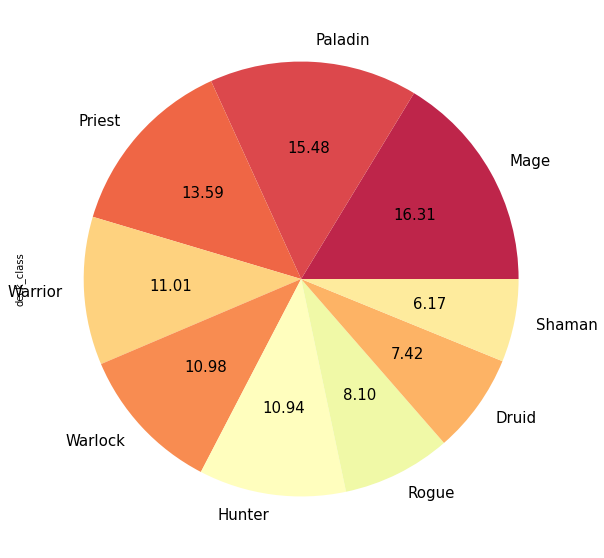

In [ ]:
deck_class_w = decks_w['deck_class'].value_counts()
deck_class_graphic = deck_class_w.to_frame().reset_index()
colors = {
    'Druid' : '#fdb365',
    'Hunter' : '#fffebe',
    'Mage' : '#be254a',
    'Paladin' : '#dc484c',
    'Priest' : '#ef6645',
    'Rogue' : '#f0f9a7',
    'Shaman' : '#feeb9d',
    'Warlock' : '#f88c51',
    'Warrior' : '#fed27f',
}

colors = collections.OrderedDict(sorted(colors.items()))

deck_class_graphic['color'] = deck_class_graphic['index'].replace(colors)
deck_class_w.plot.pie(
    y='deck_class', 
    labels=deck_class_graphic['index'], 
    colors=deck_class_graphic['color'],
    autopct='%.2f', 
    fontsize=15,
    figsize=(10, 10),
    legend=False,
)
#Para Wild

Este gráfico corresponde al formato de salvaje el cual nos indica que la clase Mago es la más utilizada.

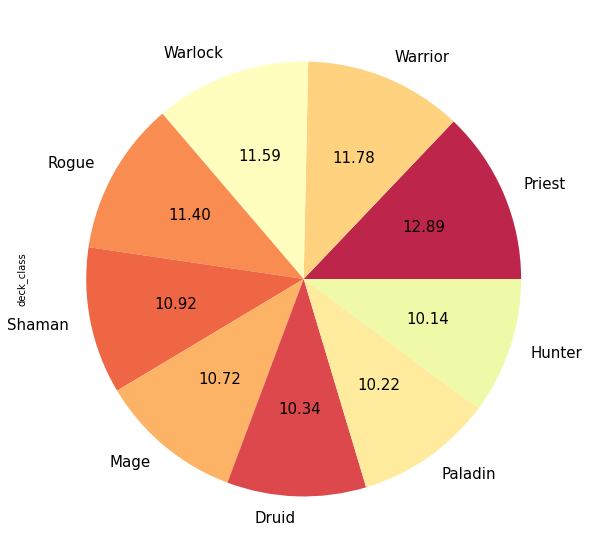

In [ ]:
deck_class_s = decks_s['deck_class'].value_counts()
deck_class_graphic = deck_class_s.to_frame().reset_index()
colors = {
    'Druid' : '#dc484c',
    'Hunter' : '#f0f9a7',
    'Mage' : '#fdb365',
    'Paladin' : '#feeb9d',
    'Priest' : '#be254a',
    'Rogue' : '#f88c51',
    'Shaman' : '#ef6645',
    'Warlock' : '#fffebe',
    'Warrior' : '#fed27f',
}
colors = collections.OrderedDict(sorted(colors.items()))

deck_class_graphic['color'] = deck_class_graphic['index'].replace(colors)
deck_class_s.plot.pie(
    y='deck_class', 
    labels=deck_class_graphic['index'], 
    colors=deck_class_graphic['color'],
    autopct='%.2f', 
    fontsize=15,
    figsize=(10, 10),
    legend=False,
)
#Para estandar

Este gráfico corresponde al formato de estándar el cual nos indica que la clase Sacerdote es la más utilizada. Y como podemos ver lo que más se juega en un formato es diferente al otro y esto nos puede indicar que la forma de jugar en cada formato es diferente y se puede evidenciar por las clases que utilizan los jugadores en cada formato la que cambia considerablemente.

Luego del filtrado se procede a comprobar los arquetipos más jugados de las clases Mago y Sacerdote, ya que estas fueron las que lideraban en los gráficos anteriores. La razón de hacer este análisis es para ver el porqué cambió de clase más utilizada en un formato en comparación a su contraparte, para aquello vamos a comparar cada clase entre los formatos Salvaje y Estándar para ver qué arquetipo se está jugando en cada uno, ya que el arquetipo de juego indica una estrategia con el uso de las cartas.

<Figure size 432x288 with 0 Axes>

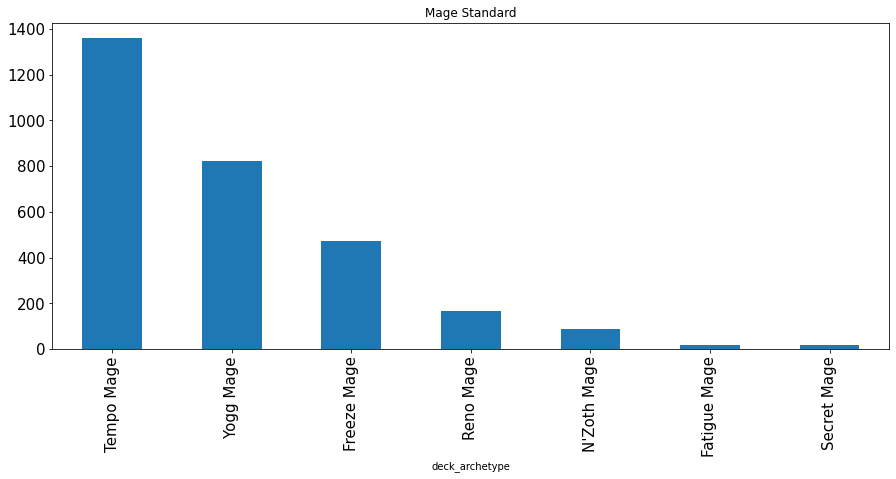

In [ ]:
decks_mage_s = decks_s[decks_s['deck_class'] == 'Mage']
contador = decks_mage_s.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Mage Standard',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

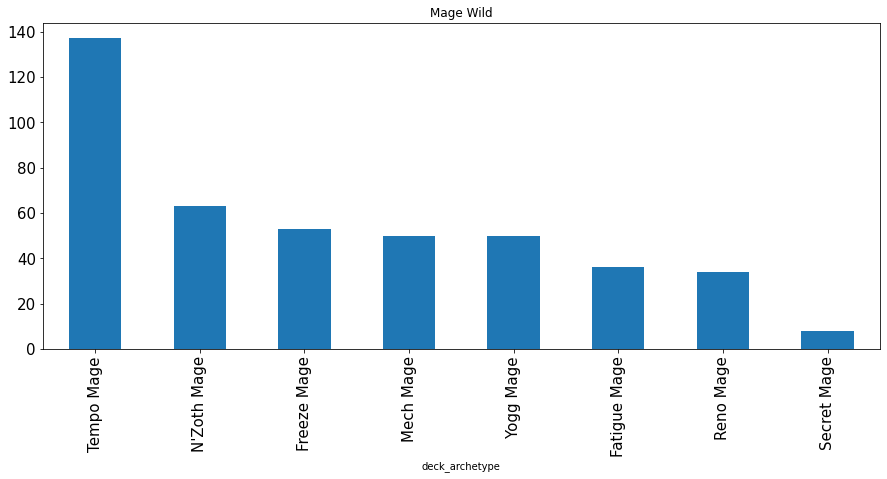

In [ ]:
decks_mage_w = decks_w[decks_w['deck_class'] == 'Mage']
contador = decks_mage_w.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Mage Wild',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

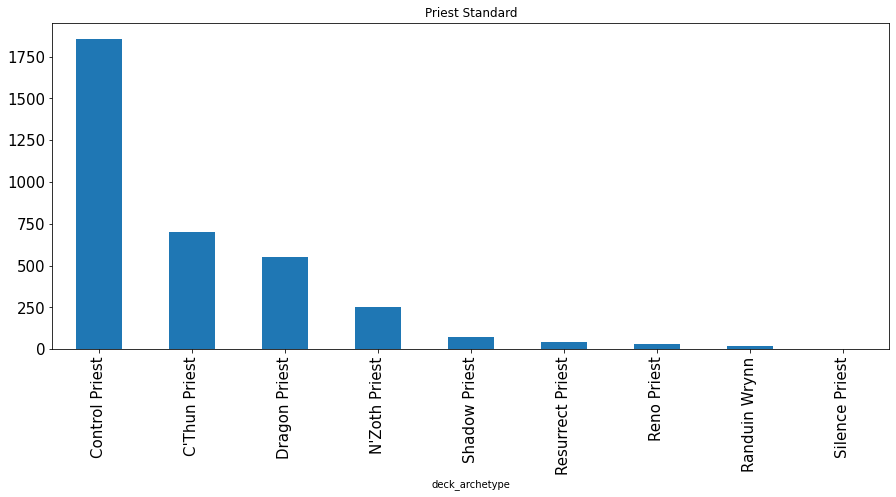

In [ ]:
decks_priest_s = decks_s[decks_s['deck_class'] == 'Priest']
contador = decks_priest_s.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Priest Standard',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

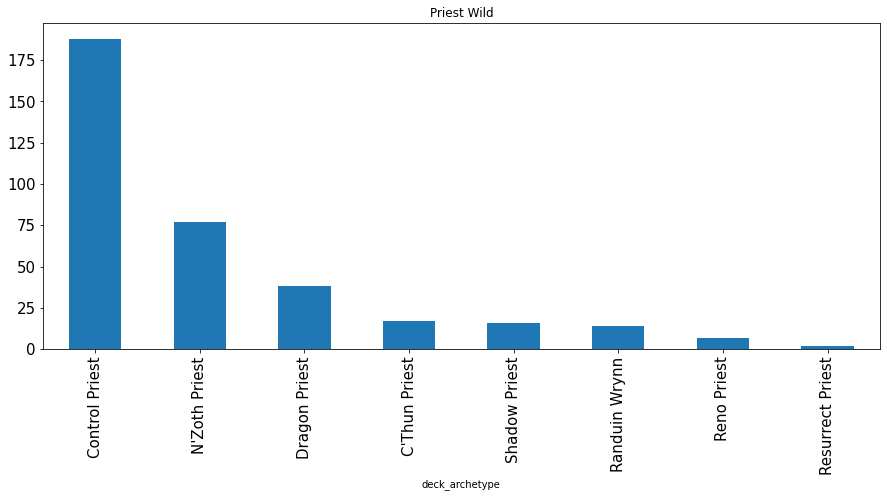

In [ ]:
decks_priest_w = decks_w[decks_w['deck_class'] == 'Priest']
contador = decks_priest_w.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Priest Wild',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

Como se puede observar en los gráficos anteriores, para el caso de la clase Sacerdote no hubo mucho cambio en los arquetipos jugados entre los formatos. Al igual que en la clase Mago. Por lo tanto se puede concluir que el cambio de la clase que lideraba en los formatos Estándar y Salvaje se debe a que dentro del juego existe la rotación de cartas que significa que las cartas de estándar de la temporada pasan al formato de salvaje y aparecen nuevas cartas para el formato estándar para reemplazar a las que se habían ido a salvaje, por lo tanto se potenciaba a ciertos mazos y ocurre que en el caso de mago que era más utilizado en estándar se fue debilitando en el formato salvaje por la potencia de otras clases. En este caso el análisis no arroja información relevante que se pueda inferir respecto a nuestra propuesta principal, ya que no existen cambios significativos en cada formato.

Luego del análisis anterior y como hearthpwn nos solicitó resolver un problema de clasificación, esta se realizará con un concepto que en la expansión "Old gods" no estaba incorporado y este es clasificar un mazo al formato que pertenece, y también luego del análisis con los arquetipos de mazos más utilizados no se obtuvo grandes conclusiones, pero se puede incorporar un problema para resolver, por lo tanto en vez de ver cuáles son los arquetipos más utilizados por raza vamos a ver qué variables se asocian entre los atributos de un mazo para verificar si existen asociaciones con arquetipos o con diferentes cartas para obtener información relevate que sea de estudio y así presentar en la plataforma recomendaciones que se pueda obtener a partir de las asociaciones.

<a name="item5"></a>
## **Preguntas y Problemas**


1. Problema de clasificación binaria basado en la variable "deck_format": consiste en una variable que es categórica que se comporta de manera binaria correspondiente a un atributo que hace referencia al formato de un mazo, y en este problema se debe encontrar la forma de poder clasificar el formato de los nuevos mazos que serán registrados en la plataforma.

2. Problema basado en encontrar asociaciones entre variables categóricas de un mazo. Dado que se registraron mazos con sus respectivos atributos, en este problema se debe encontrar cuáles son los atributos de un mazo que se asocian entre sí para obtener información relevante, ya que dentro de la plataforma se quiere implementar una sección de recomendación a través de la información que se obtenga de las asociaciones de atributos.

<a name="item6"></a>
## **Propuesta Experimental**

* Para enfrentar el problema 1, vamos a clasificar con 2 modelos de predicción de tipo categórico, estos son árbol de decisión y bosques aleatorios con el fin de identificar qué modelo es mejor para poder clasificar el formato de un nuevo mazo, y los resultados que nos entreguen los dos modelos se evaluaran respecto a la métrica de "Recall", debido a que el valor para este problema proviene de ser capaces de detectar decks Wild, los cuales son considerados como el TP de esta situación.

* Para enfrentar el problema 2, vamos a utilizar reglas de asociación de los atributos de un mazo para encontrar reglas de asociación utilizando un modelo con el que será entrenado con el algoritmo Apriori y esto será medidos por la métrica de "support" y la razón de elegir esta medida es porque nos entrega un valor de la cual podemos saber si se puede confiar en las transacciones para obtener la información que necesitamos dependiendo del valor que nos entregue.

<a name="item7"></a>
## **Experimento preliminar**

### **Experimento Problema 1**

Para realizar el experimento utilizaremos el subconjunto "filter_deck", ya que contiene todos los datos necesarios para trabajar los modelos.

In [ ]:
card_columnas = ['card_{}'.format(str(i)) for i in range(30)]

In [ ]:
def predecir_formato_arbol(decks_df, card_columnas):

    X = decks_df[card_columnas].values
    y = decks_df['deck_format'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Arbol de decision
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    print(classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    
    return clf

In [ ]:
prediccion_arbol = predecir_formato_arbol(filter_deck, card_columnas)

              precision    recall  f1-score   support

           S       0.99      0.99      0.99      6859
           W       0.94      0.94      0.94       663

    accuracy                           0.99      7522
   macro avg       0.97      0.97      0.97      7522
weighted avg       0.99      0.99      0.99      7522

Matriz de confusión: 
 [[6821   38]
 [  40  623]]


El modelo muestra un rendimiento anormalmente alto en todas sus métricas, lo cual puede significar Overfitting, pero la matriz de confusión muestra que la distribución de TP y TN refleja propiamente el comportamiento del modelo deseado.

In [ ]:
def predecir_formato_bosques(decks_df, card_columnas):

    X = decks_df[card_columnas].values
    y = decks_df['deck_format'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # random forest
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    print (classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    
    return clf

In [ ]:
prediccion_formato_bosques = predecir_formato_bosques(filter_deck, card_columnas)

              precision    recall  f1-score   support

           S       0.99      1.00      1.00      6842
           W       1.00      0.90      0.95       680

    accuracy                           0.99      7522
   macro avg       1.00      0.95      0.97      7522
weighted avg       0.99      0.99      0.99      7522

Matriz de confusión: 
 [[6842    0]
 [  67  613]]


En comparación al árbol de decisión el rendimiento es más alto en casi todas sus métricas, pero no es una buena idea seleccionar este método debido al claro overfitting observado en precisión recall y f1-score.

En ambos algoritmos observamos un alto grado de overfitting, inicialmente consideramos que esto fuese una consecuencia del alto número de mazos Standard vs. Wild dentro de los datos filtrados.


Sin embargo el problema resulto provenir de las variables card_n, las cuales aunque son técnicamente categóricas, poseen demasiadas entradas únicas para ser consideradas de esta manera en un algoritmo de clasificación binario con atributos categóricos.

In [ ]:
print("N de cartas unicas en Card_0: \n " , filter_deck['card_0'].nunique())

N de cartas unicas en Card_0: 
  178



Ante el error anterior, se presenta una nueva propuesta experimental:

###**Propuesta Experimental 1.2**
* En consecuencia del experimento anterior, se decide abordar el problema 1 como un problema de agrupación, basado en el algoritmo Kmode [3], variante de Kmeans pensada para clustering usando variables categóricas, y se mantendrá el foco en mantener el Recall de los mazos Wild lo más alto posible.

Debido a que Kmode está basado en Kmeans, es necesario convertir "deck_format" a una variable binaria numérica

In [ ]:
df_format = pd.get_dummies(filter_deck["deck_format"])
df_binary = pd.concat((df_format, filter_deck), axis=1)
df_binary = df_binary.drop(["deck_format"], axis=1)
df_binary = df_binary.drop(["S"], axis=1)
df_binary = df_binary.rename(columns={"W": "deck_format"})

Además se retiran los siguientes atributos:
* date: Debido a no ser un atributo categórico
* deck_archetype y deck_class: Ya que no cuadran en el contexto de esta propuesta.

In [ ]:
df_binary.drop(['date','deck_archetype','deck_class'], axis = 'columns', inplace=True)
df_binary.head()

,deck_format,deck_type,card_0,card_1,card_2,card_3,card_4,card_5,card_6,card_7,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
1407,0,Ranked Deck,180,180,196,196,365,365,459,459,...,1158,2291,2291,2304,2304,2949,38888,38888,39041,39041
1497,1,Ranked Deck,296,296,437,437,519,519,1003,1243,...,38496,38584,38584,38727,38727,38734,38734,38875,38875,38910
1499,0,Ranked Deck,272,272,613,613,841,1650,1650,3015,...,38863,38863,38868,38868,38958,38958,39033,39033,39041,39041
1623,0,Ranked Deck,48,48,211,242,242,290,348,559,...,2288,2288,2580,2895,2895,2949,38454,38454,38774,38774
1628,1,Ranked Deck,23,48,48,242,242,290,348,631,...,1786,1786,1914,2013,2013,2078,2288,2288,2895,2895


In [ ]:
from kmodes.kmodes import KModes
def predecir_formato_kmodes(decks_df, card_columnas):
    deck = decks_df.applymap(str)
    deck['deck_format'] = deck['deck_format'].apply(int)
    X = deck[card_columnas].values
    y = deck['deck_format'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.5)
    
    # Kmodes - Init puede ser "Random, Cao o Huang", seleccionamos Huang debido a que tiene intenciones mas claras que Random, y Cao solo permite una iteracion, como consecuencia el tiempo de ejecucion es mas largo.
    clf = KModes(n_clusters= 2, init = "Huang", n_init = 5, verbose=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
        
    print(classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    print('Costo de prediccion: ', clf.cost_)
    return clf

In [ ]:
prediccion_formato_kmodes = predecir_formato_kmodes(df_binary, card_columnas)

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     13743
           1       0.07      0.18      0.10      1301

    accuracy                           0.71     15044
   macro avg       0.49      0.47      0.46     15044
weighted avg       0.83      0.71      0.76     15044

Matriz de confusión: 
 [[10417  3326]
 [ 1066   235]]
Costo de prediccion:  417367.0


Observando los resultados, vemos que el modelo escogido posee un mal rendimiento en el recall para Wild, una posibilidad siendo que la distribución de datos da un sesgo a los datos Standard.

In [ ]:
df_binary.deck_format.value_counts()

0    27445
1     2642
Name: deck_format, dtype: int64

Aquí vemos la gran diferencia de datos entre ambas clases, Standard teniendo 10 veces más datos que lo que posee Wild, por lo que realizaremos lo siguiente:

In [ ]:
#Separamos las clases
df_standard = df_binary[df_binary.deck_format==0]
df_wild = df_binary[df_binary.deck_format==1]

In [ ]:
from sklearn.utils import resample

#Realizamos un downsample a Standard
df_downsampled = resample(df_standard,replace=False,n_samples=13724,random_state=123)

#Upsample realizado a Wild
df_upsampled = resample(df_wild,replace=True,n_samples=13724,random_state=123)

#Combinamos las clases
df_resample = pd.concat([df_downsampled, df_upsampled])

#Nueva distribucion
df_resample.deck_format.value_counts()

0    13724
1    13724
Name: deck_format, dtype: int64

Igualamos la cantidad de datos utilizando Downsample y Upsample [4], con el fin de mejorar las predicciones relacionadas a Wild.

In [ ]:
prediccion_formato_kmodes_resample = predecir_formato_kmodes(df_resample, card_columnas)

              precision    recall  f1-score   support

           0       0.47      0.78      0.58      6859
           1       0.33      0.11      0.17      6865

    accuracy                           0.44     13724
   macro avg       0.40      0.44      0.37     13724
weighted avg       0.40      0.44      0.37     13724

Matriz de confusión: 
 [[5317 1542]
 [6095  770]]
Costo de prediccion:  385826.0


* Debido a que este es un algoritmo no determinístico, los resultados pueden variar drásticamente entre iteraciones, la imagen siguiente presenta el mejor resultado obtenido entre múltiples intentos:

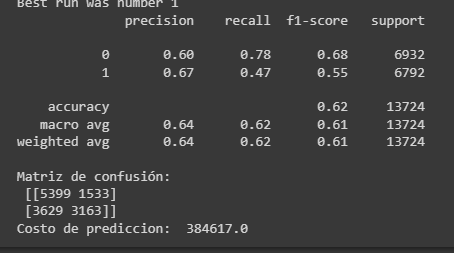

Se observa una clara mejora de las predicciones sobre Wild, con el recall llegando al 47% de los mazos de esta categoría y accuracy de 62%, lo cual dentro de la problemática es medianamente efectivo.

### **Experimento Problema 2**

Para este experimento vamos a utilizar el lenguaje R ya que poseen las librerías para utilizar regla de asociación.

In [ ]:
%%R 
install.packages('arules')
install.packages('arulesViz')
library('arules')

(as ‘lib’ is unspecified)







	‘/tmp/Rtmp2vcNi1/downloaded_packages’

(as ‘lib’ is unspecified)














































































































































































	‘/tmp/Rtmp2vcNi1/downloaded_packages’


Attaching package: ‘arules’



    abbreviate, write




In [ ]:
%%R -i filter_deck
decks_oldsgods <- filter_deck
head(decks_oldsgods)

           date deck_archetype deck_class deck_format   deck_type card_0 card_1
1407 2016-04-26     Mill Rogue      Rogue           S Ranked Deck    180    180
1497 2016-04-26  N'Zoth Hunter     Hunter           W Ranked Deck    296    296
1499 2016-04-26  C'Thun Priest     Priest           S Ranked Deck    272    272
1623 2016-04-26        Zoolock    Warlock           S Ranked Deck     48     48
1628 2016-04-26        Zoolock    Warlock           W Ranked Deck     23     48
1632 2016-04-26   Aggro Shaman     Shaman           S Ranked Deck    238    238
     card_2 card_3 card_4 card_5 card_6 card_7 card_8 card_9 card_10 card_11
1407    196    196    365    365    459    459    461    461     667     667
1497    437    437    519    519   1003   1243   1243   1261    1261    1662
1499    613    613    841   1650   1650   3015   3015  38429   38429   38433
1623    211    242    242    290    348    559    631    631     763     763
1628     48    242    242    290    348    631    631  

Haciendo un análisis previo, los atributos que hacen referencia a una carta están registrados como "card_0", "card_1" y así hasta "card_29" y por esto son atributos que no entregan ninguna información a la hora de realizar asociaciones y debido a esto no se utilizarán estos atributos.


In [ ]:
%%R
decks_oldsgods <- decks_oldsgods[, -c(6:36)]
decks_oldsgods$date <- decks_oldsgods$deck_set <- NULL
head(decks_oldsgods)

     deck_archetype deck_class deck_format   deck_type
1407     Mill Rogue      Rogue           S Ranked Deck
1497  N'Zoth Hunter     Hunter           W Ranked Deck
1499  C'Thun Priest     Priest           S Ranked Deck
1623        Zoolock    Warlock           S Ranked Deck
1628        Zoolock    Warlock           W Ranked Deck
1632   Aggro Shaman     Shaman           S Ranked Deck


Ya tenemos nuestro dataset para encontrar las asociaciones de los atributos de los mazos. Ahora vamos a observar los itemsets más frecuentes.

In [ ]:
%%R
frequentItems <- eclat(decks_oldsgods, parameter = list(supp = 0.6, maxlen = 10))

Eclat

parameter specification:
 tidLists support minlen maxlen            target  ext
    FALSE     0.6      1     10 frequent itemsets TRUE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 18052 

create itemset ... 
set transactions ...[88 item(s), 30087 transaction(s)] done [0.02s].
sorting and recoding items ... [2 item(s)] done [0.00s].
creating bit matrix ... [2 row(s), 30087 column(s)] done [0.00s].
writing  ... [3 set(s)] done [0.00s].
Creating S4 object  ... done [0.00s].


In [ ]:
%%R
items.sorted <- sort(frequentItems, by="support")
inspect(items.sorted)

    items                                  support   count
[1] {deck_type=Ranked Deck}                0.9156114 27548
[2] {deck_format=S}                        0.9121880 27445
[3] {deck_format=S, deck_type=Ranked Deck} 0.8411274 25307


Viendo los itemsets más frecuentes nos encontramos con 3 lo que nos puede indicar que cuando se aplique el algoritmo apriori nos va a entregar pocas asociaciones. Por lo tanto lo vamos a comprobar aplicando la regla.

In [ ]:
%%R
regla <- apriori(decks_oldsgods, parameter=list(support=0.2, confidence=0.3))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.2      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 6017 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[88 item(s), 30087 transaction(s)] done [0.02s].
sorting and recoding items ... [2 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [4 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
%%R
regla_sort <- sort(regla, by="lift")
inspect(head(regla_sort))

    lhs                        rhs                     support   confidence
[1] {deck_format=S}         => {deck_type=Ranked Deck} 0.8411274 0.9220987 
[2] {deck_type=Ranked Deck} => {deck_format=S}         0.8411274 0.9186511 
[3] {}                      => {deck_format=S}         0.9121880 0.9121880 
[4] {}                      => {deck_type=Ranked Deck} 0.9156114 0.9156114 
    coverage  lift     count
[1] 0.9121880 1.007085 25307
[2] 0.9156114 1.007085 25307
[3] 1.0000000 1.000000 27445
[4] 1.0000000 1.000000 27548


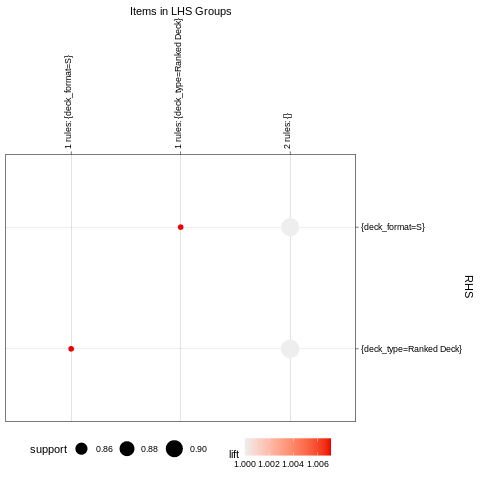

In [ ]:
%%R
library('arulesViz')
plot(regla, method = "grouped")

Debido a los resultados anteriores, existen asociaciones entre las variables "deck_format" y "deck_type" con un "support" de 0.8411274 lo que es un buen indicador para confiar en estar dos asociaciones, pero un punto relevante es que solo se encontraron dos por lo que mucha información no nos entrega, y la razón se debe a la poca cantidad de atributos que quedan después de la limpieza de columnas que no servían para este análisis.

##**Resultados Relevantes**

1.- Dentro del primer problema, se logró una tasa de recall del 47% en tipo Wild, y 62% de accuracy, resultados más bajos que lo que se esperaban, además la precisión sobre los mazos standard fue solo del 60%, por lo que la chance de introducir Falsos positivos no es ignorable.

El mayor factor que afecto esta predicción fue la disparidad en el soporte por clase, pensamos que si existiese una mayor cantidad de mazos Wild naturales, la clasificación sería mejor debido a que hay menor incertidumbre como el sesgo que puede generar el Oversampling dentro del set de datos.

2.- Dentro del segundo problema, se encontraron 2 asociaciones relevantes de los que sí se puede hacer realizar un análisis por ejemplo que los mazos que se crean en el formato "S" o estándar están muy relacionados con mazos de tipo "Ranked Deck" o mazo competitivo, lo que nos hace inferir que los usuarios que se creaban un mazo para formato estándar lo creaban para jugar de forma competitiva, pero en este caso el problema es abordable, pero entrega muy poca información por lo que se recomendaría realizar un parseo a los datos de las columnas por ejemplo a las referentes a las cartas, ya que un código de id no nos entrega información.

<a name="item8"></a>
## **Trabajo realizado**


**Armin Rodríguez:** Limpieza de datos y apoyo en exploración de datos en la sección de los gráficos de pie.

**Rodrigo Valenzuela:** Redacción reporte y presentación, desarrollo de preguntas, retroalimentación de cambios, desarrollo de experimentos del problema 1. 

**Nicolás Hidalgo:** Redacción y Exploración de datos, observaciones en los graficos de barra sobre formato Estandar y Salvaje. 

**Pablo Nahuelpán:** Redacción de preguntas y propuestas, desarrollo de experimentos del problema 2.

<a name="item9"></a>
# **Referencias:**

[1] HeartStone. (2014, 11 marzo). [Software]. En Blizzard Entertainment (24.2). Peter McConnell. https://hearthstone.blizzard.com/es-es

[2] HeathPwn. (2022). HeathPwn. https://www.hearthpwn.com/

[3] H. Bonthu, “KModes Clustering Algorithm for Categorical data,” Analytics Vidhya, Jun. 13, 2021. https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/.

[4] K. Pykes, “Oversampling and Undersampling,” Medium, Sep. 10, 2020. https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf.

# **Repositorio almacenado y dataset:**
https://github.com/ZatmanUfro/ID-2022-2-Hearthstone

https://raw.githubusercontent.com/ArminRodriguez1/ig_Datos/main/data.csv

[5] History of Hearthstone. (2017, 6 julio). Kaggle. Recuperado 7 de octubre de 2022, de https://www.kaggle.com/datasets/romainvincent/history-of-hearthstone


# **Referencia página oficial:**

[6] Un nuevo modo de juego. (2016, 1 marzo). Hearthstone. https://hearthstone.blizzard.com/es-mx/news/19995505

<a name="item10"></a>
# **Anexo:**

*   TP: True positive (Positivo verdadero)
*   TN: True negative (Positivo negativo)
*   FP: False negative (Falso negativo
*   FN: False negative (Falso negativo)